<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/titanic_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip -q install scikeras

In [64]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv
!ls -al data
!wc -l data/*.csv

2025-03-28 20:57:48 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv [61194/61194] -> "data/titanic.csv" [1]
total 68
drwxr-xr-x 2 root root  4096 Mar 28 20:57 .
drwxr-xr-x 1 root root  4096 Mar 28 19:36 ..
-rw-r--r-- 1 root root 61194 Mar 28 20:57 titanic.csv
892 data/titanic.csv


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Preprocess Data

See data dictionary in [https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/input]

In [66]:
df = pd.read_csv('./data/titanic.csv') #, index_col='PassengerId')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## drop columns

drop columns that are unique per record.

In [67]:
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

## deal with NaN fields

In [68]:
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Cabin,687
Embarked,2


In [69]:
# Cabin has too many NaN records, drop it
df = df.drop(['Cabin'], axis=1)

In [70]:
# use median age for missing Age
df['Age'] = df['Age'].fillna( df['Age'].median() )
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,2


In [71]:
# for the unknow embarked port, put U for unknown
df['Embarked'] = df['Embarked'].fillna('U')
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


In [72]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,28.0,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


## categorise data

        Survival Count  Mortality Count  Survaval Ratio %
Pclass                                                   
1                  136               80         62.962963
2                   87               97         47.282609
3                  119              372         24.236253


<Figure size 300x200 with 0 Axes>

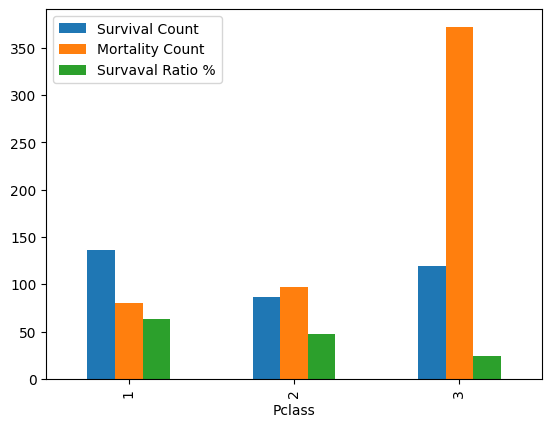

In [73]:
# Pclass

# calculate survival rate of each pclass:
pclass_survival_count = df.query('Survived == 1')['Pclass'].value_counts().sort_index()
pclass_mortal_count = df.query('Survived == 0')['Pclass'].value_counts().sort_index()
pclass_survival_ratio = pclass_survival_count / (pclass_survival_count + pclass_mortal_count) * 100

pclass_stats = pd.concat([pclass_survival_count, pclass_mortal_count, pclass_survival_ratio],
                         keys=['Survival Count', 'Mortality Count', 'Survaval Ratio %'], axis=1)
print(pclass_stats)

plt.figure(figsize=(3,2))
pclass_stats.plot(kind='bar')
plt.show()

By the look of the above, there seems to have some ordinality of Pclass on survival rate. So leave it as is.

In [74]:
# Sex only has 2 values, so turn them into 0 or 1
df['Sex'] = df['Sex'].astype('category').cat.codes
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,S
887,1,1,0,19.0,0,0,30.0000,S
888,0,3,0,28.0,1,2,23.4500,S
889,1,1,1,26.0,0,0,30.0000,C


In [75]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked']

for var in categorical:
  df = pd.concat([df, pd.get_dummies(df[var], prefix=var, dtype='long')], axis=1)
  del df[var]

In [76]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_U
0,0,3,1,22.0,1,0,7.2500,0,0,1,0
1,1,1,0,38.0,1,0,71.2833,1,0,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1,0
3,1,1,0,35.0,1,0,53.1000,0,0,1,0
4,0,3,1,35.0,0,0,8.0500,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,0,0,1,0
887,1,1,0,19.0,0,0,30.0000,0,0,1,0
888,0,3,0,28.0,1,2,23.4500,0,0,1,0
889,1,1,1,26.0,0,0,30.0000,1,0,0,0


## scale continous columns

In [77]:
## scale continuous columns

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cont = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

for c in cont:
  df[c] = df[c].astype('float64')
  df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))

In [78]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Pclass,891.0,-8.772133e-17,1.000562,-1.566107,-0.369365,0.827377,0.827377,0.827377
Sex,891.0,6.475870e-01,0.477990,0.000000,0.000000,1.000000,1.000000,1.000000
Age,891.0,2.272780e-16,1.000562,-2.224156,-0.565736,-0.104637,0.433312,3.891554
SibSp,891.0,4.386066e-17,1.000562,-0.474545,-0.474545,-0.474545,0.432793,6.784163
Parch,891.0,5.382900e-17,1.000562,-0.473674,-0.473674,-0.473674,-0.473674,6.974147
Fare,891.0,3.987333e-18,1.000562,-0.648422,-0.489148,-0.357391,-0.024246,9.667167
Embarked_C,891.0,1.885522e-01,0.391372,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,891.0,8.641975e-02,0.281141,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_S,891.0,7.227834e-01,0.447876,0.000000,0.000000,1.000000,1.000000,1.000000


In [79]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_U
0,0,0.827377,1,-0.565736,0.432793,-0.473674,-0.502445,0,0,1,0
1,1,-1.566107,0,0.663861,0.432793,-0.473674,0.786845,1,0,0,0
2,1,0.827377,0,-0.258337,-0.474545,-0.473674,-0.488854,0,0,1,0
3,1,-1.566107,0,0.433312,0.432793,-0.473674,0.420730,0,0,1,0
4,0,0.827377,1,0.433312,-0.474545,-0.473674,-0.486337,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,-0.369365,1,-0.181487,-0.474545,-0.473674,-0.386671,0,0,1,0
887,1,-1.566107,0,-0.796286,-0.474545,-0.473674,-0.044381,0,0,1,0
888,0,0.827377,0,-0.104637,0.432793,2.008933,-0.176263,0,0,1,0
889,1,-1.566107,1,-0.258337,-0.474545,-0.473674,-0.044381,1,0,0,0


In [81]:
df.to_csv('./data/preproc_data.csv', index=None)

## Split datasets

In [82]:
df = pd.read_csv('./data/preproc_data.csv')
X = df.drop(['Survived'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 10), (179, 10), (712,), (179,))

# Tensorflow model

In [85]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_tfmodel(lyrs=[8, 32], optim='Adam', activation='linear',
                  init='glorot_uniform', dr=0.0):
  """ lyrs: list of hidden layer dimensions
    optim: optimisation method
    activation: activation functions 'linear', 'relu', etc.
    init: kernel initialiser of layer
    dr: dropout rate
  """
  model = Sequential()
  # input layer
  model.add(Dense(lyrs[0], input_dim=X_train.shape[1],
                  activation=activation, kernel_initializer=init))

  # hidden layers
  for dim in lyrs[1:]:
    model.add(Dense(dim), activation=activation, kernel_initializer=init)

  model.add(Dropout(dr))

  # output layer
  model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

  model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

  return model


In [86]:
tf_model = build_tfmodel(lyrs=[8], activation='relu')
tf_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [87]:
tf_train_result = tf_model.fit(X_train, y_train, batch_size=32, epochs=100,
                        validation_split=0.2, verbose=0)

acc = np.mean(tf_train_result.history['accuracy'])
loss = np.mean(tf_train_result.history['loss'])
val_acc = np.mean(tf_train_result.history['val_accuracy'])
val_loss = np.mean(tf_train_result.history['val_loss'])
print(f"  training accuracy: {acc:.4f}, loss: {loss:.4f}")
print(f"validation accuracy: {val_acc:.4f}, loss: {val_loss:.4f}")

  training accuracy: 0.7870, loss: 0.4684
validation accuracy: 0.8063, loss: 0.4435


In [ ]:
tf_train_result.history.keys()

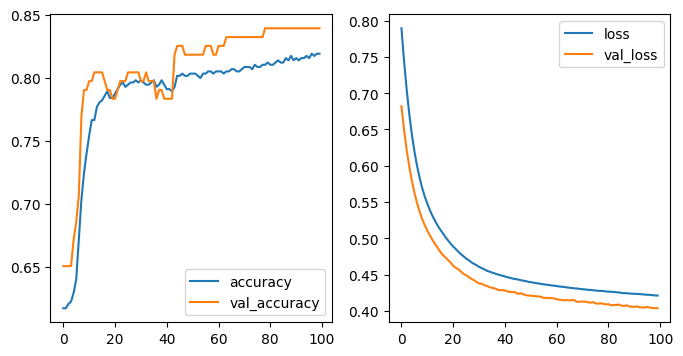

In [88]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.plot(tf_train_result.history['accuracy'])
ax1.plot(tf_train_result.history['val_accuracy'])
ax1.legend(['accuracy', 'val_accuracy'])

ax2.plot(tf_train_result.history['loss'])
ax2.plot(tf_train_result.history['val_loss'])
ax2.legend(['loss', 'val_loss'])

plt.show()

In [91]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline

model = KerasClassifier(build_fn=build_tfmodel, verbose=0)

grid_params = {
    'model__epochs': [50, 100],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__init': ['glorot_uniform', 'normal', 'uniform'],
    'model__batch_size': [16, 32, 64]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

gs = GridSearchCV(estimator=model, param_grid=grid_params, cv=5, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'